In [1]:
import numpy as np
import scipy
import scipy.io as sio

from FlagRep import FlagRep, chordal_distance

from matplotlib import pyplot as plt

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split



In [2]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

In [3]:
#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

In [4]:
class_names = {1: 'Alfalfa',
               2: 'Corn-notill',
               3: 'Corn-mitill',
               4: 'Corn',
               5: 'Grass-pasture',
               6: 'Grass-trees',
               7: 'Grass-pasture-mowed',
               8: 'Hay-windrowed',
               9: 'Oats',
               10: 'Soybean-notill',
               11: 'Soybean-mitill',
               12: 'Soybean-clean',
               13: 'Wheat',
               14: 'Woods',
               15: 'Buildings-Grass-Trees-Drives',
               16: 'Stone-Steel-Towers'}

Playing around...

In [5]:


# Load the hyperspectral image and ground truth
data = sio.loadmat('../data/indian_pines/Indian_pines.mat')['indian_pines']  # Shape: (145, 145, 220)
labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)

def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data (145x145x220).
    :param labels: The ground truth labels (145x145).
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image, avoiding border pixels (due to patch size)
    for i in range(half_patch, data.shape[0] - half_patch):
        for j in range(half_patch, data.shape[1] - half_patch):
            if labels[i, j] == target_class:
                # Extract the patch from both the data and the labels
                label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
                
                # Check if all pixels in the label patch are of the target class
                if np.all(label_patch == target_class):
                    # Extract the corresponding data patch
                    patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                    patches.append(patch)
                    patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)

# Example usage
patch_size = 11 #is insanely good for non-flagrep
target_class = 2  # For example, class 2 represents a certain crop type
patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)

print(f"Extracted {len(patches)} patches where all pixels are of class {target_class}. Each patch has shape {patches[0].shape}.")

Extracted 94 patches where all pixels are of class 2. Each patch has shape (11, 11, 220).


In [6]:
mod_data = []
mod_labels = []
for target_class in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]: #[8,10,11,14]:#[8,10,11,14]:#:
    patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)
    if len(patches) > 0:
        flat_patches = []
        for patch in patches:
            # Your 3D array of size 11x11x200
            array_3d = patch  # Example array

            center_x, center_y = patch_size//2, patch_size//2

            # Create a list of all (x, y) coordinates and compute their Manhattan distances from the center
            coords = [(x, y) for x in range(patch_size) for y in range(patch_size)]
            distances = [(x, y, max(abs(x - center_x), abs(y - center_y))) for x, y in coords]

            # Sort coordinates by distance
            sorted_coords = sorted(distances, key=lambda item: item[2])

            # Create the 2D array by unwrapping the 3D array based on sorted coordinates
            flat_patch = np.array([array_3d[x, y, :] for x, y, _ in sorted_coords])
            flat_patches.append(flat_patch)

            # Create a hierarchy vector containing the Chebyshev distances in the same sorted order
            hierarchy_vector = np.array([distance for _, _, distance in sorted_coords])

            # Find the indices where the hierarchy vector changes value
            change_indices = np.where(np.diff(hierarchy_vector) != 0)[0] + 1  # Add 1 because diff reduces length by 1

        mod_labels +=[target_class]*len(patches)
        mod_data += flat_patches

    print(f"Extracted {len(patches)} patches where all pixels are of class {class_names[target_class]}. Each patch has shape {patch_size}.")

Extracted 0 patches where all pixels are of class Alfalfa. Each patch has shape 11.
Extracted 94 patches where all pixels are of class Corn-notill. Each patch has shape 11.
Extracted 16 patches where all pixels are of class Corn-mitill. Each patch has shape 11.
Extracted 0 patches where all pixels are of class Corn. Each patch has shape 11.
Extracted 48 patches where all pixels are of class Grass-pasture. Each patch has shape 11.
Extracted 28 patches where all pixels are of class Grass-trees. Each patch has shape 11.
Extracted 0 patches where all pixels are of class Grass-pasture-mowed. Each patch has shape 11.
Extracted 126 patches where all pixels are of class Hay-windrowed. Each patch has shape 11.
Extracted 0 patches where all pixels are of class Oats. Each patch has shape 11.
Extracted 197 patches where all pixels are of class Soybean-notill. Each patch has shape 11.
Extracted 505 patches where all pixels are of class Soybean-mitill. Each patch has shape 11.
Extracted 13 patches w

Text(0, 0.5, 'PC2')

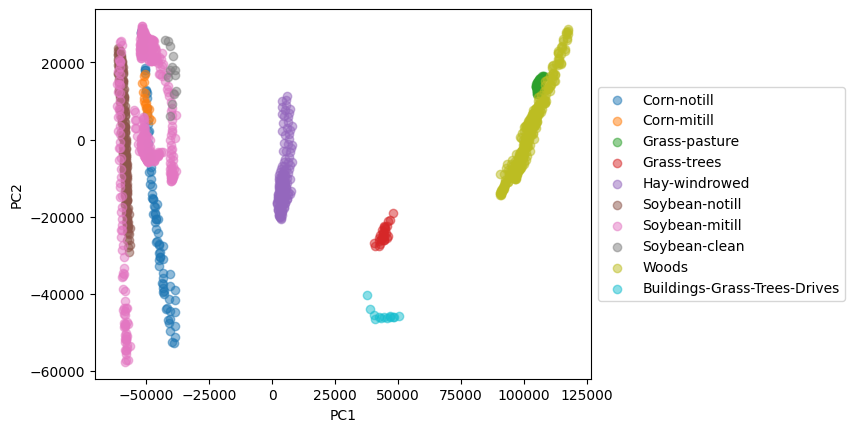

In [7]:
pca = PCA(n_components = 2)
vis_data = pca.fit_transform(np.vstack([m.flatten() for m in mod_data]))

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 't-SNE2')

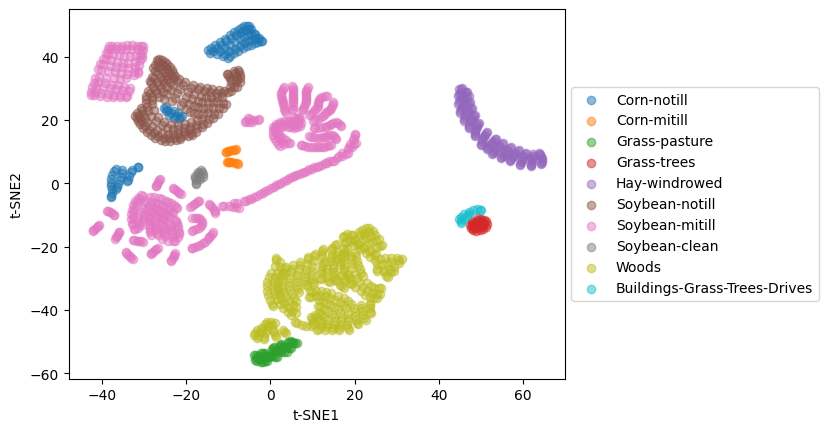

In [8]:
tsne = TSNE(n_components = 2, init = "random", random_state = 10)
vis_data = tsne.fit_transform(np.vstack([m.flatten() for m in mod_data]))

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [9]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
vis_data_train, vis_data_test, y_train, y_test = train_test_split(vis_data, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)


# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn(vis_data_train, vis_data_test, y_train, y_test, k_values)


k=1, Accuracy: 1.0000
k=3, Accuracy: 0.9976
k=5, Accuracy: 1.0000
k=7, Accuracy: 0.9952


In [10]:
Aset = [np.arange(i) for i in change_indices]
mod_flags = []
mod_f_types = []
for pt in mod_data:
    flag_pt, f_type = FlagRep(pt.T, Aset, eps_rank=500)
    mod_flags.append(flag_pt)
    mod_f_types.append(f_type)


In [11]:
p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_flags[i]
        y = mod_flags[j]
        fl_type_x = mod_f_types[i]
        fl_type_y = mod_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

In [12]:
mod_f_types

[array([ 1,  7, 14, 19, 24]),
 array([ 1,  7, 13, 18, 24]),
 array([ 1,  7, 11, 18, 24]),
 array([ 1,  7, 13, 19, 26]),
 array([ 1,  6, 13, 21, 27]),
 array([ 1,  5, 15, 22, 29]),
 array([ 1,  6, 14, 23, 28]),
 array([ 1,  7, 16, 25, 30]),
 array([ 1,  7, 16, 25, 29]),
 array([ 1,  8, 17, 25, 34]),
 array([ 1,  9, 18, 27, 36]),
 array([ 1,  9, 19, 29, 42]),
 array([ 1,  8, 19, 31, 43]),
 array([ 1,  7, 19, 33, 46]),
 array([ 1,  7, 20, 32, 44]),
 array([ 1,  8, 21, 34, 44]),
 array([ 1,  9, 21, 33, 43]),
 array([ 1,  9, 21, 33, 42]),
 array([ 1,  9, 21, 33, 42]),
 array([ 1,  9, 20, 32, 44]),
 array([ 1,  8, 18, 30, 41]),
 array([ 1,  7, 17, 30, 40]),
 array([ 1,  6, 16, 29, 39]),
 array([ 1,  6, 16, 28, 38]),
 array([ 1,  7, 14, 19, 26]),
 array([ 1,  6, 12, 20, 27]),
 array([ 1,  5, 13, 21, 28]),
 array([ 1,  7, 16, 23, 30]),
 array([ 1,  7, 17, 24, 30]),
 array([ 1,  7, 17, 24, 30]),
 array([ 1,  7, 16, 23, 31]),
 array([ 1,  8, 17, 26, 36]),
 array([ 1,  8, 18, 27, 39]),
 array([ 1

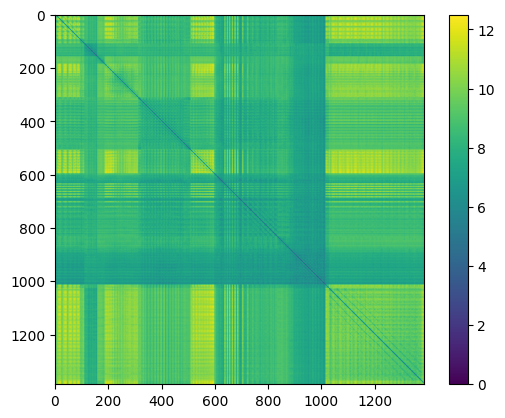

In [13]:
plt.imshow(dist_mat)
plt.colorbar()

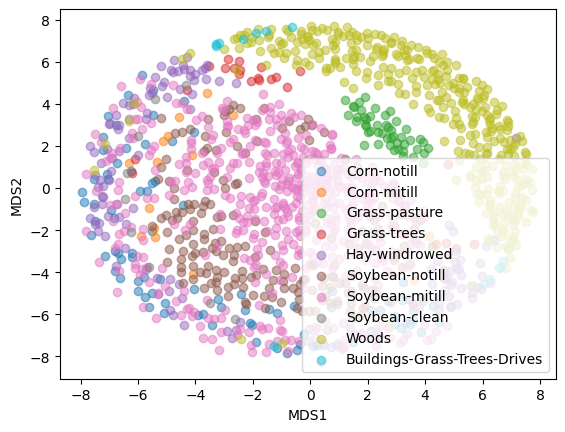

In [14]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

Text(0, 0.5, 't-SNE2')

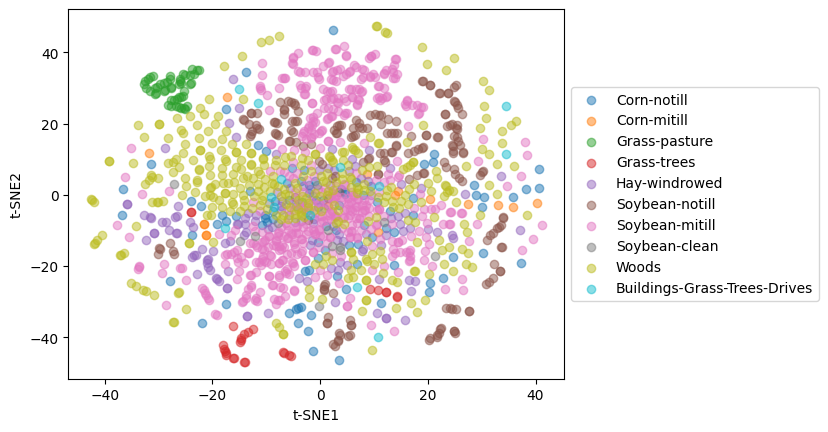

In [15]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [16]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 0.5420
k=3, Accuracy: 0.4772
k=5, Accuracy: 0.4221
k=7, Accuracy: 0.4053


In [17]:


n_sing_vals = np.max(np.vstack(mod_f_types))

mod_svds = []
svd_f_types = []
for x in mod_data:
    U,_,_ = np.linalg.svd(x.T)
    mod_svds.append(U[:,:n_sing_vals])
    svd_f_types.append(list(np.arange(1,n_sing_vals+1)))

In [18]:
p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_svds[i]
        y = mod_svds[j]
        fl_type_x = svd_f_types[i]
        fl_type_y = svd_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

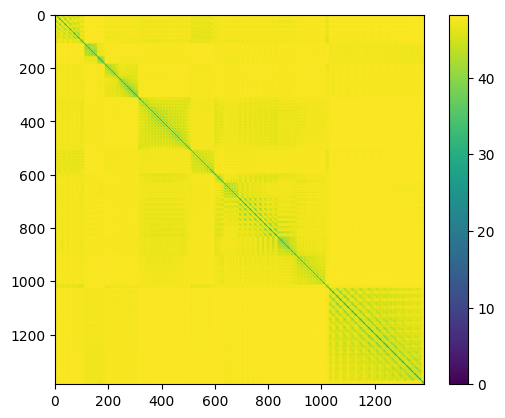

In [19]:
plt.imshow(dist_mat)
plt.colorbar()

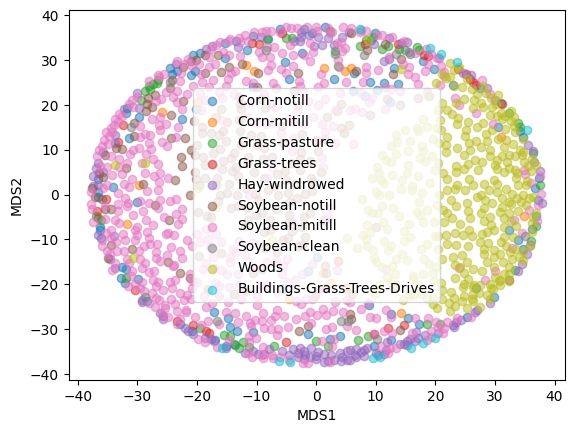

In [20]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

Text(0, 0.5, 't-SNE2')

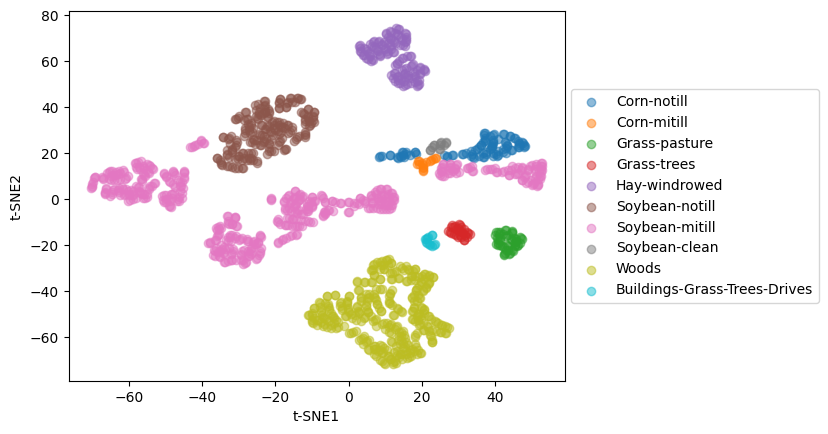

In [21]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [22]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 1.0000
k=3, Accuracy: 1.0000
k=5, Accuracy: 1.0000
k=7, Accuracy: 1.0000


In [23]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
vis_data_train, vis_data_test, y_train, y_test = train_test_split(vis_data, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)


# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn(vis_data_train, vis_data_test, y_train, y_test, k_values)


k=1, Accuracy: 1.0000
k=3, Accuracy: 1.0000
k=5, Accuracy: 0.9976
k=7, Accuracy: 0.9976
